# Reconstruction of DOSY NMR signals

**Authors**: 

* Alexandre Zouaoui (alexandre.zouaoui@ens-paris-saclay.fr)
* Charles Sejourne (charles.sejourne@ens-paris-saclay.fr)

## Part 1

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

### Style

In [3]:
sns.set_style("darkgrid")
plt.rcParams["font.size"] = 14

### Generation of synthetic data

#### Question 1

Download the diffusion signal $\overline{x} \in \mathbb{R}^N$ where $N=200$.

---

In [4]:
# Load data from text file
x = np.loadtxt("x.txt")
N = len(x)
print(f"The data has N={N} entries")

The data has N=200 entries


#### Question 2

Create $T$ using an exponential sampling strategy:
\begin{align}
\forall n \in \{1, \ldots, N\}, \quad T^{(n)} = T_{\min} \exp \big(- (n - 1) \frac{\log(T_\min / T_\max)}{N - 1} \big)
\end{align}
where $T_\min = 1$ and $T_\max = 1000$.

---

In [5]:
T_min = 1
T_max = 1000

# Create T using an exponential sampling strategy
T = np.array([T_min * np.exp(-(n - 1) * (np.log(T_min / T_max)) / (N - 1)) 
              for n in range(1, N + 1)])

#### Question 3

Display the original signal $\overline{x}$ as a function of $T$ (log scale on the horizontal axis).

---

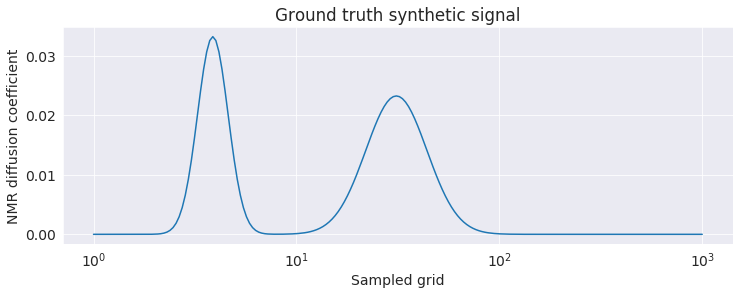

In [6]:
# Display the original signal x as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 4))
plt.title("Ground truth synthetic signal")
plt.plot(T, x)
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log");

#### Question 4

Create $t$ using a regular sampling strategy:
$$\forall m \in \{1, \ldots, M \}), \quad t^{(m)} = t_\min + \frac{m - 1}{M - 1} (t_\max - t_\min)$$
where $M=50$, $t_\min=0$ and $t_\max=1.5$.

---

In [7]:
M = 50
t_min = 0
t_max = 1.5

# Create t using a regular sampling strategy
t = np.array([t_min + (m - 1) / (M - 1) * (t_max - t_min) 
              for m in range(1, M + 1)])

#### Question 5

Construct matrix $K$ using:
$$\forall m \in \{1, \ldots, M \}, \; \forall n \in \{1, \ldots, N \}, \quad K^{(m, n)} = \exp(-T^{(n)}t^{(m)})$$

---

In [8]:
# Create the matrix K of size M x N
K = np.exp(- np.outer(t, T))

#### Question 6

Simulate the noisy data according to $y = K \overline{x} + w$ by taking $w \sim \mathcal{N}(0, \sigma^2 I_M)$ with $\sigma = 0.01 z^{(1)}$ where $z = K\overline{x}$

---

In [9]:
z = K.dot(x)
σ = 0.01 * z[0]

# Instanciate the noise
np.random.seed(42)
w = σ * np.random.randn(M)

# Simulate the noisy data
y = z + w

#### Question 7

Display the resulting noisy data $y$ as a function of $t$.

---

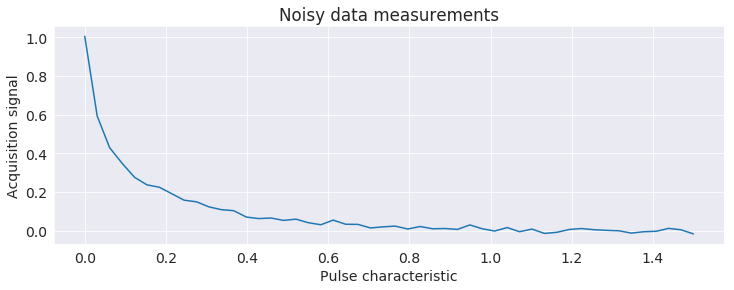

In [10]:
# Display the resulting noisy data y as a function of t
plt.figure(figsize=(12, 4))
plt.title("Noisy data measurements")
plt.plot(t, y)
plt.xlabel("Pulse characteristic")
plt.ylabel("Acquisition signal");

### Comparison of regularization strategies

For every penalization functions $g$ listed at the end of the document,
1. Discuss the existence and uniqueness of a solution to
$$ \hat{x} = \text{arg}\min_{x \in \mathbb{R}^N} \frac{1}{2} \parallel Kx - y \parallel^2 + \beta g(x)$$
2. Propose an approach to solve the problem above.
3. Implement the approach and display the restored signal $\hat{x}$
4. Compute the normalized quadratic error between $\hat{x}$ and $\overline{x}$:
$$ E(\hat{x}, \overline{x}) = \frac{\parallel \hat{x} - \overline{x} \parallel^2}{\parallel \overline{x} \parallel^2}$$
5. When needed, search manually for the best choice for parameter $\beta$ in terms of reconstruction error.

##### Normalized quadratic error implementation

In [11]:
def quadratic_error(x_hat, x):
    """
    Compute the normalized quadratic error between the restored signal
    and the ground truth signal
    
    Parameters
    ------------
    - x_hat : numpy.array
        Restored signal
        
    - x : numpy.array
        Ground truth signal
    
    Returns
    ------------
    - error : float
        Normalized quadratic error
    """
    
    error = np.linalg.norm(x_hat - x, ord=2)**2 / np.linalg.norm(x, ord=2)**2 
    return error

We will study three different priors

#### Smoothness prior

$$\forall x \in \mathbb{R}^N, \quad g(x) = \frac{1}{2} \parallel Dx \parallel^2$$
where $D \in \mathbb{R}^{N \times N}$ is the discrete gradient operator defined such that:
$$\forall n \in \{1, \ldots, N \}, [Dx]^{(n)} = x^{(n)} - x^{(n-1)}$$
with the circular convention that $x^{(0)} = x^{(N)}$. The role of such regularization term is to promote the reconstruction of smooth signals.

---

#### Problem solution and approach

1. First we notice that the function $f: x \mapsto \frac{1}{2} \parallel Kx - y \parallel^2 + \frac{\beta}{2} \parallel Dx \parallel^2$ is a **convex** function by deriving its Hessian matrix $\nabla^2_f: x \mapsto K^T K + D^T D$. From here it appears that $\nabla^2_f$ is a **positive semi definite** matrix since we have: $\forall x \in \mathbb{R}^N, \; x^T \,\nabla^2_f(x)\, x = \parallel Kx \parallel^2 + \beta \parallel Dx \parallel^2 \geq 0$. 

In addition, we can check that the hessian matrix is invertible. We have that $\text{Ker} (K^T K + \beta D^T D) = \text{Ker} K \cap \text{Ker} D$, since given $x \in \text{Ker} (K^T K + \beta D^T D)$,

\begin{align}
(K^T K + \beta D^T D) x = 0 & \iff x^T (K^T K + \beta D^T D) x = 0 \\
& \iff K x = 0 \quad \text{and} \quad D x = 0\\
& \iff x \in \text{Ker} K \cap \text{Ker} D\\
\end{align}

By definition of $D$, we have $\forall x \in \text{Ker} D, Dx = 0 \iff x = \alpha 1_N$ where $1_N$ is a vector of dimension $N$ whose entries are only 1s. Since $K$ is a matrix with only strictly positive coefficients by definition, we get: $\forall x \in \text{Ker} D, Kx > 0$, therefore $\text{Ker}(K) \cap \text{Ker}(D) = \{0_{\mathbb{R}^N}\}$ and the Hessian matrix is **invertible**.

Using $\text{Ker}(K) \cap \text{Ker}(D) = \{0_{\mathbb{R}^N}\}$ we now get that the hessian matrix $\nabla^2_f$ is in fact a **positive definite** matrix, i.e.: $\forall x \in \mathbb{R}^N\backslash\{0_{\mathbb{R}^N}\}, \; x^T\,\nabla^2_f(x)\, x = \parallel Kx \parallel^2 + \beta \parallel Dx \parallel^2 > 0$. As a result, $f$ is a **strictly convex** function and it admits the optimization problem admits a unique solution.

2. As a result, we can directly compute the optimization problem **closed form** solution by solving the linear system induced by setting the gradient to 0, as follow:

$$\nabla_f(\hat{x}) = 0 \iff (K^T K + \beta D^T D) \hat{x} = K^T y \iff \boxed{\hat{x} = (K^T K + \beta D^T D)^{-1} K^T y}$$

Best normalized quadratic error between the original and reconstruction signals: 0.3849


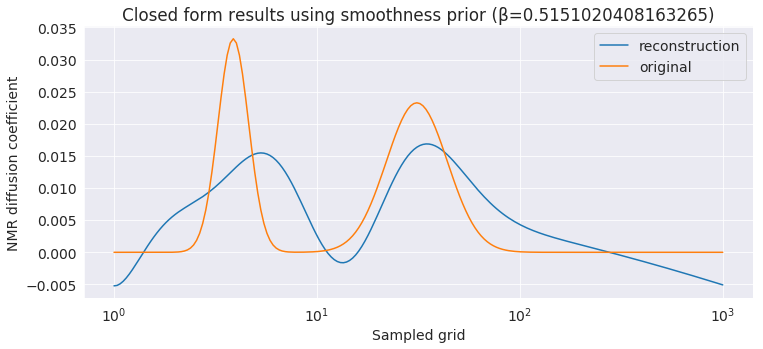

In [21]:
# Define D the discrete gradient operator
D = np.eye(N)
for i in range(N - 1):
    D[i+1, i] = -1
D[0, -1] = -1


# Search for the best parameter β
best_error = np.inf
best_x_hat = None
best_β = None

β_range = np.linspace(1e-2, 1, num=50, endpoint=True)

for β in β_range:
    # Closed form solution
    x_hat = np.linalg.solve(K.T.dot(K) + β * D.T.dot(D), K.T.dot(y))
    # Compute the normalized quadratic error between x_hat and x
    error = quadratic_error(x_hat, x)
    
    # Update best settings
    if error < best_error:
        best_error = error
        best_x_hat = x_hat
        best_β = β
        
print(f"Best normalized quadratic error between"
      f" the original and reconstruction signals: {round(best_error, 4)}")

# Display the reconstructed x_hat as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 5))
plt.title(f"Closed form results using smoothness prior (β={best_β})")
plt.plot(T, best_x_hat, label="reconstruction")
# Display the original signal x as a function of T using log scale horizontal axis
plt.plot(T, x, label="original")
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log")
plt.legend(frameon=True);

**Comment:**

We recovered two peaks although they do not occur for the same sample. In addition, the recovered peaks are not as sharp as the ground truth ones. Moreover we recover some negative values for the NMR diffusion coefficient which does not make sense on a physics standpoint. 

#### Smoothness prior + constraints


$$\forall x \in \mathbb{R}^N, \quad g(x) = \frac{1}{2} \parallel Dx \parallel^2 + \iota_{[x_\min, x_\max]^N}(x)$$
with $0 < x_\min < x_\max$ the minimum and maximum values of the original signal $\overline{x}$.

---

1. The term $\iota_{[x_\min, x_\max]^N}$ reduces the domain of the objective to $[x_\min, x_\max]^N$, which is a closed convex subset of $\mathbb{R}^N$. It is bounded, which means there exists $\hat{x} \in [x_\min, x_\max]^N$ such that:

$$\hat{x} = \arg \min_{x \in \mathbb{R}^N} \frac{1}{2} \parallel Kx - y \parallel^2 + \frac{1}{2} \parallel Dx \parallel^2 + \iota_{[x_\min, x_\max]^N}(x)$$

Moreover, since the objective is strictly convex, $\hat{x}$ is unique.


2. The objective is no longer differentiable, which excludes gradient descent as a potential algorithm to solve the optimization problem. Thus we must rely on the **projected gradient algorithm**. Let us denote $g: x \mapsto \frac{1}{2}\parallel Kx - y \parallel^2 + \frac{1}{2} \parallel Dx \parallel^2$ and $f: x \mapsto \iota_{[x_\min, x_\max]^N}(x)$ to recover the notations seen in class in order to apply the Forward-Backward algorithm (specifically its projected gradient variant). 

We need to compute the $\nu$-Lipschitzian gradient where $\nu = \max(|a_i|)_{i \in \{1, \ldots, N\}}$ where the $a_i$ are the eigenvalues of the Hessian matrix of $g$ (i.e. $K^T K + \beta D^T D$) and the proximal operator of $\gamma f$ simply becomes the projection on the set $[x_\min, x_\max]^N$.

Best normalized quadratic error between the original and reconstruction signals: 0.1542


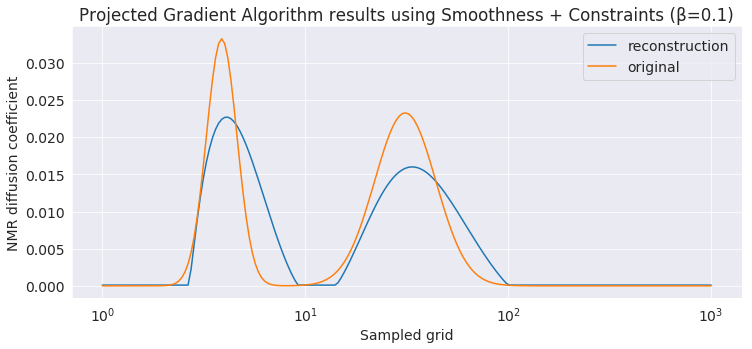

In [23]:
# Define D the discrete gradient operator
D = np.eye(N)
for i in range(N - 1):
    D[i+1, i] = -1
D[0, -1] = -1

# Set the clipping values
x_min = 1e-4
x_max = 1


# Search for best parameter β
best_error = np.inf
best_x_hat = None
best_β = None
tol = 1e-3 # stopping criterion parameter

β_range = np.linspace(0.1, 1, num=10, endpoint=True)

for β in β_range:
    
    # Compute the largest eigenvalues of the Hessian of g(x)
    # We use ``eigvalsh`` to only compute the eigenvalues
    # the ``h`` in ``eigvalsh`` refers to a faster algorithm tailored
    # to real symmetric matrices such as $K^T K + \beta D^T D$
    ν =  np.sort(np.linalg.eigvalsh(K.T.dot(K) + β * D.T.dot(D)))[-1]

    # Set the step size
    γ = 1 / ν
    δ = 2 - γ * ν / 2
    λ = 0.95
    assert δ - λ > 0

    # Initialization
    x_curr = np.ones_like(x)
    x_next = np.zeros_like(x)

    # Implement the Projected Gradient Algorithm
    while np.any(np.abs(x_next - x_curr) / (np.abs(x_curr) + 1e-8) > tol): # stopping criterion
        x_curr = x_next
        y_curr = x_curr - γ * (K.T.dot(K.dot(x_curr) - y) + β * D.T.dot(D.dot(x_curr)))
        x_next = x_curr + λ * (np.clip(y_curr, x_min, x_max) - x_curr)

    x_hat = x_next
    
    error = quadratic_error(x_hat, x)

    if error < best_error:
        best_error = error
        best_x_hat = x_hat
        best_β = β

# Display the reconstruction error
print(f"Best normalized quadratic error between"
      f" the original and reconstruction signals: {round(best_error, 4)}")

# Display the reconstructed x_hat as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 5))
plt.title(f"Projected Gradient Algorithm results using Smoothness + Constraints (β={best_β})")
plt.plot(T, best_x_hat, label="reconstruction")
# Display the original signal x as a function of T using log scale horizontal axis
plt.plot(T, x, label="original")
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log")
plt.legend(frameon=True);

**Comment:**

We recover the two peaks and clearly see the effect of clipping on the minimal value of the reconstructed signal. Adding the boundaries constraints yields a better reconstruction error compared to only using the smoothness prior. However, the recovered peaks centers are slightly shifted from their ground truth positions.  

#### Sparsity prior

$$\forall x \in \mathbb{R}^N, \quad g(x) = \parallel x \parallel_1$$

Here we want to induce a parcimonious solution where only a few coefficients are non-null.

---

1. Here the function $x \mapsto \frac{1}{2} \parallel Kx - y \parallel^2 + \parallel x \parallel_1$ is strictly convex but not differentiable. Hence there is a global minima but we cannot obtain it by setting the gradient to 0. 

2. The optimization problems consists in minimizing the **sum of two functions** that have different properties. To recover the notations from the course, let us note $f: x \mapsto \parallel x \parallel_1$ and $g: x \mapsto \frac{1}{2} \parallel Kx - y \parallel^2_2$. Now $g$ is lower-semi-continuous, proper, convex and **differentiable** with a $\nu$-Lipschitzian gradient corresponding to the highest eigenvalue of the Hessian matrix $K^T K$ and $f$ is lower-semi-continuous, proper, convex and **separable** therefore we can easily compute its proximal operator and apply it element-wise.

We can now apply the Forward-Backward algorithm in its iterative shrinkage-thresholding variant (ISTA).

Best normalized quadratic error between the original and reconstruction signals: 0.11


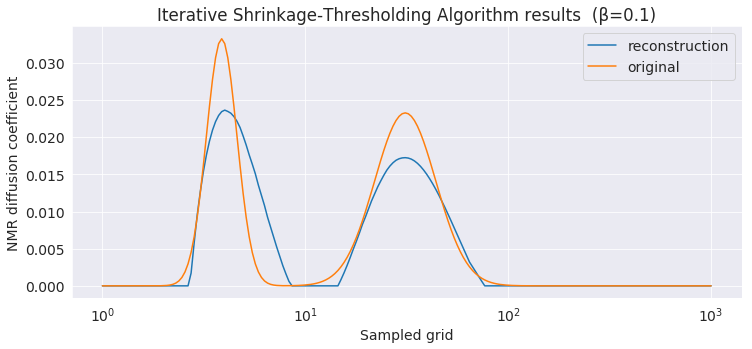

In [25]:
# Search for best parameter β
best_error = np.inf
best_x_hat = None
best_β = None
tol = 1e-3 # stopping criterion

β_range = np.linspace(0.1, 0.5, num=10, endpoint=True)



for β in β_range:
    # Compute the largest eigenvalues of the Hessian of g(x)
    # We use ``eigvalsh`` to only compute the eigenvalues
    # the ``h`` in ``eigvalsh`` refers to a faster algorithm tailored
    # to real symmetric matrices such as $K^T K$
    ν =  np.sort(np.linalg.eigvalsh(K.T.dot(K)))[-1]

    # Set the step size
    γ = 1 / ν
    δ = 2 - γ * ν / 2
    λ = 0.95
    assert δ - λ > 0

    # Initialization
    x_curr = np.zeros_like(x)
    x_next = np.ones_like(x)

    # Implement the Projected Gradient Algorithm
    while np.any(np.abs(x_next - x_curr) / (np.abs(x_curr) + 1e-8) > tol): # stopping criterion
        x_curr = x_next
        y_curr = x_curr - γ * K.T.dot(K.dot(x_curr) - y)
        # Thresholding
        x_next = x_curr + λ * (np.sign(y_curr) * np.maximum(np.abs(y_curr) - (β / 2 * γ), 0) - x_curr)
        

    x_hat = x_next
    
    error = quadratic_error(x_hat, x)

    if error < best_error:
        best_error = error
        best_x_hat = x_hat
        best_β = β

# Display the reconstruction error
print(f"Best normalized quadratic error between"
      f" the original and reconstruction signals: {round(best_error, 4)}")

# Display the reconstructed x_hat as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 5))
plt.title(f"Iterative Shrinkage-Thresholding Algorithm results  (β={round(best_β, 4)})")
plt.plot(T, best_x_hat, label="reconstruction")
# Display the original signal x as a function of T using log scale horizontal axis
plt.plot(T, x, label="original")
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log")
plt.legend(frameon=True);

**Comment:**

We clearly recover the two ground truth peaks. We get a better reconstruction error than in the two previous settings. The reconstructed signal is sparse as there are only a few coefficients that are non null. Since we have **prior knowledge** of the task at hand, that is recovering different species of molecules by looking at their Nuclear Magnetic Resonance diffusion coefficient, aiming for a **sparse solution appears to be a good idea**.

**Conclusion:**

Note however that these results based on synthetic data **highly depend on the noise** added to the ground truth measurement. We encountered instances of the problem where the smoothness + constraints (case 2) yielded a lower error than the sparsity prior. As a consequence, we **fixed the random seed** generating the noise to make the results reproducible.

## Part 2 - Maximum entropy regularization

We use a standard strategy for restoring the target signal that consists in finding a solution of the so-called maximum entropy problem:

$$\hat{x} = \arg \min_{x \in \mathbb{R}^N} \frac{1}{2} \parallel Kx - y \parallel^2 + \beta \;\text{ent}(x)$$

where $\forall x \in \mathbb{R}^N, \quad \text{ent}(x) = \sum_{n=1}^N \varphi(x^{(n)})$, with:

$$\varphi(u) =
\begin{cases}
u \log u  & \text{if $u$ > 0} \\
0 & \text{if $u$ = 0} \\
+ \infty & \text{elsewhere}
\end{cases}$$

### Question 1.

Is $\text{ent}$ convex? proper? lower-semicontinuous? differentiable?

---

1. The function $\text{ent}$ defined below is proper since its domain is non-empty and it never atteins $- \infty$.
2. $\text{ent}$ is lower-semicontinuous since it is separable and each components is continuous on $\mathbb{R}_+$ as $\lim_{u \rightarrow 0} u \log u = 0$ and equal to $+ \infty$ on $\mathbb{R}_-$
3. $\text{ent}$ separable components are differentiable on $\mathbb{R}_+^*$ and we have: $\forall u \in \mathbb{R}_+, \phi'(u) = 1 + \log u$. Since the separable components derivatives are monotonically strictly increasing we get that $\text{ent}$ is **strictly convex** on its domain ${\mathbb{R}_+}^N$

### Question 2.

Does the optimization problem have a solution? Is it unique?

---

If we define $f: x \in \mathbb{R}^N \mapsto \frac{1}{2} \parallel Kx - y \parallel^2 + \beta \;\text{ent}(x) \in \mathbb{R}$, using the previous question we can say that $f$ can only be minimized on ${\mathbb{R}_+^*}^N$ on which $\text{ent}$ is strictly convex. Since $K$ entries are strictly positive, we get that $x \in {\mathbb{R}_+^*}^N \mapsto \frac{1}{2} \parallel Kx - y \parallel^2$ is strictly convex. As a result, the optimization problem has a **unique solution**.

### Question 3.

Give the expression of the proximity operator of $\text{ent}$ at some $x \in \mathbb{R}^N$ using the Lambert $W$-function.

---

As a reminder, Lambert $W$-function is such that $W: h(w) \mapsto w$ where $h(w): w \mapsto w \exp w$. In other words, it is the inverse function of $h$ but it has no analytic form and can be approximated numerically.


We start by noticing that the $\text{ent}$ function is separable by definition, thus its proximal operator is also separable.

Since the minimizer can only belong to $\mathbb{R}_+^*$, we define $\text{prox}_{\gamma \text{ent}}(u) = \arg \min_{z > 0} \gamma z \log z + \frac{1}{2} \parallel z - u \parallel^2$

Since $\text{ent}$ separable components are differentiable on $\mathbb{R}_+^*$, we compute $\text{prox}_{\gamma \text{ent}}(u)$ by solving the equation obtained by setting the derivative of $g_u: z \in \mathbb{R}_+^* \mapsto \gamma z \log z + \frac{1}{2} \parallel z - u \parallel^2$  to 0.

We get:


\begin{align}
g_u'(z^*) = 0 & \iff \log z^* + 1 + \frac{z^* - u}{\gamma} = 0 \\
& \iff \frac{z^*}{\gamma} + \log (\frac{z^*}{\gamma}) = \frac{u}{\gamma} -1 - \log \gamma \\
& \iff \frac{z^*}{\gamma} \exp(\frac{z^*}{\gamma}) = \exp (\frac{u}{\gamma} - 1 - \log \gamma)\\
\end{align}

We recognize the Lambert $W$-function defined above, therefore we get:

\begin{align}
g_u'(z^*) = 0 & \iff \frac{z^*}{\gamma} = W \big( \exp(\frac{u}{\gamma} - 1 - \log \gamma)\big) \\
& \iff  z^* = \gamma W \big( \exp(\frac{u}{\gamma} - 1 - \log \gamma)\big) \\
\end{align}

Finally, we obtain a closed-form solution that involves Lambert $W$-function: $$\boxed{\text{prox}_{\gamma \text{ent}}(u) = \gamma W \big( \exp(\frac{u}{\gamma} - 1 - \log \gamma)\big)}$$

Note: we wrote $\log$ when we meant to use $\ln$ in the above derivations.

In [26]:
# Lambert W-function implementation
def W_func(u, tol=1e-3):
    """
    Computes W-function using numerical approximation
    of ::math::$W(\exp(u))$
    
    Parameter
    ---------
    - u : float
        Argument to compute $W(\exp u)$
    """
    if u > 100:
        return u - np.log(u)
    elif u < -20:
        return 0
    else:
        # Haley's method
        w = 1
        v = np.inf * w
        while np.any(np.abs(w - v) / np.abs(w) > tol):
            v = w
            e = np.exp(w)
            f = w * e - np.exp(u)  # Iterate to make this quantity zero
            w = w - f / ((e * (w+1) - (w+2) * f / (2*w+2)))
        return w

# Vectorize Lambert W-function
vec_W_func = np.vectorize(W_func)

### Question 4.

Proprose a Forward-Backward and a Douglas-Rachford algorithm to solve problem (1)

---

1. Given the previous answers, we have that $h_0: x \in {\mathbb{R}_+^*}^N \mapsto \frac{1}{2} \parallel Kx - y \parallel^2$ is convex, proper, lower-semicontinuous and differentiable with its gradient Lispchitz constant $\nu$ equal to the largest eigenvalue of $K^T K$. Moreover, $h_1: x \in {\mathbb{R}_+^*}^N \mapsto \beta \text{ent}(x)$ is convex, proper and lower-semicontinuous. Hence we can use now use the Forward Backward algorithm. Given that we use $\gamma \in ]0, \frac{2}{\nu}[$, $\delta = 2 - \frac{\gamma \nu}{2} \in ]1, 2[$ and $(\lambda_n)_{n \in \mathbb{N}}$ such that $\sum_{n \in \mathbb{N}} \lambda_n (\delta - \lambda_n) = + \infty$, we can now write Foward Backward main loop, i.e. $\forall n \in \mathbb{N}$:

$$\begin{cases}
y_n = x_n - \gamma K^T (K x_n - y) \\
x_{n+1} = x_n + \lambda_n (\gamma \beta W_{\text{vec}} (\exp(\frac{y_n}{\gamma \beta} - 1 - \ln(\gamma \beta)) - x_n)
\end{cases}
$$

Where $W_{\text{vec}}$ denotes the vectorized version of Lambert $W$-function.

Note that since $h_1$ is differentiable (on ${\mathbb{R}_+^*}^N$) we could possibly use a reverse formulation where we swap $h_0$ and $h_1$ although it requires computing the Lipschitz constant of the gradient of $h_1$.

2. In addition, we can use Douglas Rachford as it requires even weaker hypotheses. We only need to compute the proximal operator of $h_0$:

$$\text{prox}_{\gamma h_0} (x) = \arg \min_{z \in \mathbb{R}^N} \frac{\gamma}{2} \parallel Kz - y \parallel^2 + \frac{1}{2} \parallel z - x \parallel^2$$

By setting the gradient of $z \in \mathbb{R}^N \mapsto \frac{\gamma}{2} \parallel Kz - y \parallel^2 + \frac{1}{2} \parallel z - x \parallel^2$ to $0_{\mathbb{R}^N}$, we get:

$$\text{prox}_{\gamma h_0} (x) = (\gamma K^T K + I_N)^{-1} (\gamma K^T y + x)$$

Given $\gamma \in ]0, + \infty[$ and $(\lambda_n)_{n \in \mathbb{N}}$ such that $\sum_{n \in \mathbb{N}} \lambda_n (2 - \lambda_n) = + \infty$, we can now write Douglas Rachford main loop, i.e. $\forall n \in \mathbb{N}$:

$$\begin{cases}
y_n = \gamma \beta W_{\text{vec}} (\exp(\frac{x_n}{\gamma \beta} - 1 - \ln(\gamma \beta)) \\
z_n = (\gamma K^T K + I_N)^{-1} (\gamma K^T y + 2 y_n - x_n) \\
x_{n+1} = x_n + \lambda_n (z_n - y_n)
\end{cases}
$$

### Question 5.

Implement them both and evaluate their performances for $\beta = 10^{-2}$

---

Normalized quadratic error between the original and reconstruction signals: 0.6212


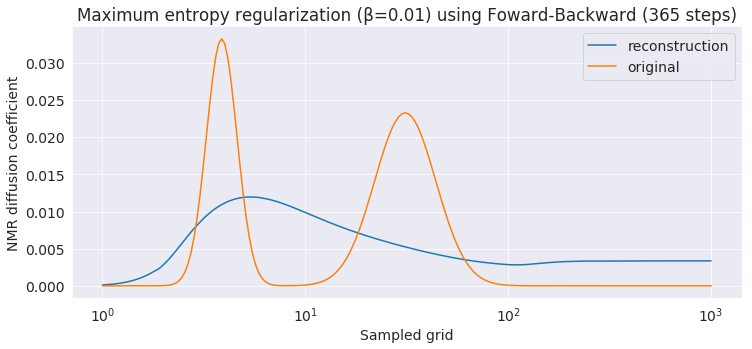

In [28]:
# Setup
tol = 1e-3 # stopping criterion
β = 1e-2

# Compute the largest eigenvalues of the Hessian of g(x)
# We use ``eigvalsh`` to only compute the eigenvalues
# the ``h`` in ``eigvalsh`` refers to a faster algorithm tailored
# to real symmetric matrices such as $K^T K$
ν =  np.sort(np.linalg.eigvalsh(K.T.dot(K)))[-1]

# Set the step size
γ = 1 / ν
δ = 2 - γ * ν / 2
λ = 1
assert δ - λ > 0


# Initialization
x_curr = np.zeros_like(x)
x_next = np.ones_like(x)

counter = 0

# Implement the Forward Backward algorithm
while np.any(np.abs(x_next - x_curr) / (np.abs(x_curr) + 1e-8) > tol): # stopping criterion
    x_curr = x_next
    y_curr = x_curr - γ * K.T.dot(K.dot(x_curr) - y)
    # Use vectorized Lambert W function
    x_next = x_curr + λ * (γ * β * vec_W_func(y_curr / (γ * β) - 1 - np.log(γ * β)) - x_curr)
    counter += 1


x_hat = x_next

error = quadratic_error(x_hat, x)


# Display the reconstruction error
print(f"Normalized quadratic error between"
      f" the original and reconstruction signals: {round(error, 4)}")

# Display the reconstructed x_hat as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 5))
plt.title(f"Maximum entropy regularization (β={β}) using Foward-Backward ({counter} steps)")
plt.plot(T, x_hat, label="reconstruction")
# Display the original signal x as a function of T using log scale horizontal axis
plt.plot(T, x, label="original")
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log")
plt.legend(frameon=True);

Normalized quadratic error between the original and reconstruction signals: 0.8287


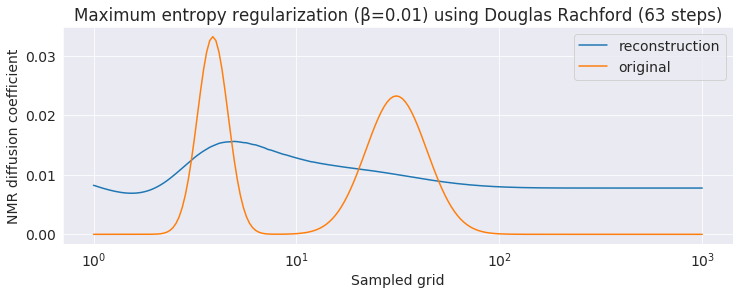

In [29]:
# Douglas-Rachford algorithm implementation

# Setup
tol = 1e-3 # stopping criterion
β = 1e-2

# Set the step size
γ = 0.1
λ = 1.9

# Compute once the matrix inversion
_inv = np.linalg.inv(γ * K.T.dot(K) + np.eye(N))


# Initialization
x_curr = np.zeros_like(x)
x_next = np.ones_like(x)

counter = 0

# Implement Douglas Rachford algorithm
while np.any(np.abs(x_next - x_curr) / (np.abs(x_curr) + 1e-8) > tol): # stopping criterion
#for _ in range(n_iter):
    x_curr = x_next
    #y_curr = x_curr - γ * K.T.dot(K.dot(x_curr) - y)
    #y_curr = γ * β * vec_W_func(x_curr / (γ * β) - 1 - np.log(γ * β))
    y_curr = _inv.dot(γ * K.T.dot(y) + x_curr)
    #z_curr = _inv.dot(γ * K.T.dot(y) + 2 * y_curr - x_curr)
    z_curr = γ * β * vec_W_func((2 * y_curr - x_curr) / (γ * β) - 1 - np.log(γ * β))
    # Use vectorized Lambert W function
    x_next = x_curr + λ * (z_curr - y_curr)
    counter += 1
        
        
x_hat = x_next

error = quadratic_error(x_hat, x)

# Display the reconstruction error
print(f"Normalized quadratic error between"
      f" the original and reconstruction signals: {round(error, 4)}")

# Display the reconstructed x_hat as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 4))
plt.title(f"Maximum entropy regularization (β={β}) using Douglas Rachford ({counter} steps)")
plt.plot(T, x_hat, label="reconstruction")
# Display the original signal x as a function of T using log scale horizontal axis
plt.plot(T, x, label="original")
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log")
plt.legend(frameon=True);

**Comment:**

* We use a fairly high tolerance (``tol = 1e-3``) otherwise computations become quite long. $\beta = 0.01$ does not seem to be the best hyperparameter. We note in this setting that Douglas Rachford needs fewer steps than Forward Backward although the requirements are less strict. In addition, Douglas Rachford does not impose any theoretical limits on the step size $\gamma$ other than it being strictly positive.

* In the next question we search for the best parameter $\beta$ in terms of reconstruction error.

### Question 6.

What is the best choice for parameter $\beta$ in terms of reconstruction error between the estimated object and the ground truth?

---

Best normalized quadratic error between the original and reconstruction signals: 0.1409
CPU times: user 38.7 s, sys: 46 s, total: 1min 24s
Wall time: 22.4 s


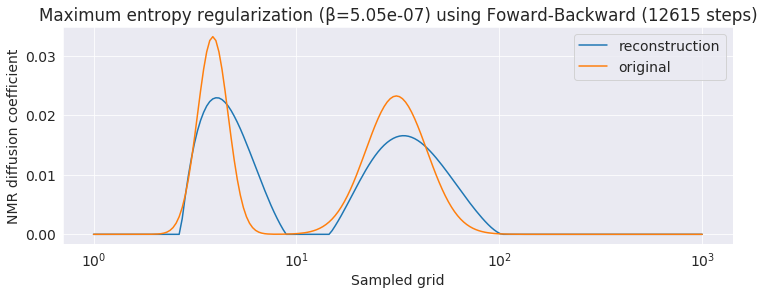

In [32]:
%%time

# Search for best parameter β
best_error = np.inf
best_x_hat = None
best_β = None
best_counter = None
tol = 1e-3 # stopping criterion

β_range = np.linspace(1e-8, 1e-6, num=3, endpoint=True)

# Compute the largest eigenvalues of the Hessian of g(x)
# We use ``eigvalsh`` to only compute the eigenvalues
# the ``h`` in ``eigvalsh`` refers to a faster algorithm tailored
# to real symmetric matrices such as $K^T K$
ν =  np.sort(np.linalg.eigvalsh(K.T.dot(K)))[-1]

# Set the step size
γ = 1 / ν
δ = 2 - γ * ν / 2
λ = 1
assert δ - λ > 0

for β in β_range:

    # Initialization
    x_curr = np.zeros_like(x)
    x_next = np.ones_like(x)
    
    counter = 0

    # Implement the Forward Backward algorithm
    while np.any(np.abs(x_next - x_curr) / (np.abs(x_curr) + 1e-8) > tol): # stopping criterion
        x_curr = x_next
        y_curr = x_curr - γ * K.T.dot(K.dot(x_curr) - y)
        # Use vectorized Lambert W function
        x_next = x_curr + λ * (γ * β * vec_W_func(y_curr / (γ * β) - 1 - np.log(γ * β)) - x_curr)
        counter += 1
        
        
    x_hat = x_next
    
    error = quadratic_error(x_hat, x)

    if error < best_error:
        best_error = error
        best_x_hat = x_hat
        best_β = β
        best_counter = counter

# Display the reconstruction error
print(f"Best normalized quadratic error between"
      f" the original and reconstruction signals: {round(best_error, 4)}")

# Display the reconstructed x_hat as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 5))
plt.title(f"Maximum entropy regularization (β={best_β}) "
          f"using Foward-Backward ({best_counter} steps)")
plt.plot(T, x_hat, label="reconstruction")
# Display the original signal x as a function of T using log scale horizontal axis
plt.plot(T, x, label="original")
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log")
plt.legend(frameon=True);

Best normalized quadratic error between the original and reconstruction signals: 0.2472
CPU times: user 2min 48s, sys: 3min 11s, total: 6min
Wall time: 1min 33s


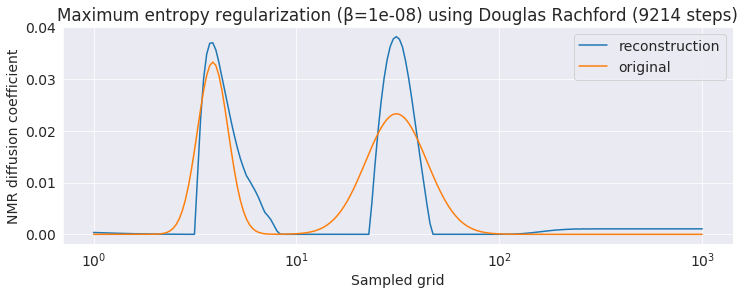

In [33]:
%%time
# Douglas-Rachford algorithm implementation

# Search for best parameter β
best_error = np.inf
best_x_hat = None
best_β = None
best_counter = None
tol = 1e-3 # stopping criterion

β_range = np.linspace(1e-8, 1e-6, num=3, endpoint=True)

# Set the step size
γ = 0.1
λ = 1.9

# Compute once the matrix inversion
_inv = np.linalg.inv(γ * K.T.dot(K) + np.eye(N))

for β in β_range:    

    # Initialization
    x_curr = np.zeros_like(x)
    x_next = np.ones_like(x)
    
    counter = 0
    
    # Implement Douglas Rachford algorithm
    while np.any(np.abs(x_next - x_curr) / (np.abs(x_curr) + 1e-8) > tol): # stopping criterion
        x_curr = x_next
        y_curr = _inv.dot(γ * K.T.dot(y) + x_curr)
        # Use vectorized Lambert W function
        z_curr = γ * β * vec_W_func((2 * y_curr - x_curr) / (γ * β) - 1 - np.log(γ * β))
        x_next = x_curr + λ * (z_curr - y_curr)
        counter += 1
        
        
    x_hat = x_next
    
    error = quadratic_error(x_hat, x)

    if error < best_error:
        best_error = error
        best_x_hat = x_hat
        best_β = β
        best_counter = counter

# Display the reconstruction error
print(f"Best normalized quadratic error between"
      f" the original and reconstruction signals: {round(best_error, 4)}")

# Display the reconstructed x_hat as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 5))
plt.title(f"Maximum entropy regularization (β={best_β}) "
          f"using Douglas Rachford ({best_counter} steps)")
plt.plot(T, x_hat, label="reconstruction")
# Display the original signal x as a function of T using log scale horizontal axis
plt.plot(T, x, label="original")
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log")
plt.legend(frameon=True);

**Comment:**

* We notice that once again Douglas Rachford converges in fewer steps. However the fact it actually takes longer might be related to the Lambert $W$-function computation which seems to be our bottleneck here.

* In addition, while the two peaks are recovered by both algorithms, the Forward Backward solution is closer to the ground truth with respect to the peaks relative value. However the Douglas Rachford solution leads to peaks positions that look more accurate.

### Question 7.

Compare the maximum entropy regularization with the ones proposed in the previous part in terms of reconstruction quality.

---

**Comment:** 

* In order to get a meaningful comparison, we fixed the tolerance to ``tol = 1e-3`` in all the algorithms that rely on a stopping criterion (that only excludes the smoothness prior) and we use a random seed to make the results reproducible.

**Quantitative analysis**

Algorithm variant | Best normalized quadratic error | Stopping criterion (tolerance)
--- | --- | ---
*Smoothness prior* | 0.3849 | ``None``
*Smothness prior* + *constraints* | 0.1542 | ``tol=1e-3``
*Sparsity prior* | **0.11** | ``tol=1e-3``
*Maximum entropy regularization* (*Forward Backward*) | 0.1409 | ``tol=1e-3``
*Maximum entropy regularization* (*Douglas Rachford*) | 0.2472 | ``tol=1e-3``

* **Qualitative analysis**

We would have expected *Maximum entropy regularization* to trump previous priors but the *sparsity prior* still yields the best reconstruction by a fair margin over the *Forward Backward* variant of *Maximum entropy regularization*, while being significantly faster. One could argue that the high tolerance used in the Lambert $W$-function approximation (``tol=1e-3``) might be responsible for such results but we found it to provide reasonable results in a reasonable computational time (there is indeed a trade-off between computation time and precision at play).

Note that every regularization scheme requires to carefully fine-tune the regularization parameter $\beta$ in order to obtain good results. This can be a time consuming process. In addition, there is no principled way to know how to choose $\beta$ beforehand, hence we rely on a hyperparameter grid search. Finally, we are able to measure the reconstruction quality only because we have access to the ground truth solution but this is not the case in practice.

### Question 8.

In practice tuning the parameter $\beta$ is difficult. Using information about the level of noise corrupting the data, we can formulate a more practical optimization problem

$$ \text{minimize}_{x \in \mathbb{R}^N} \; \text{ent}(x) \; \text{s.t.} \; \parallel Kx - y \parallel^2 \leq \eta M \sigma^2 $$

with $\eta > 0$ and we expect $\eta$ to be close to 1.

-------

Let us rewrite the optimization problem in the following equivalent way:

$$ \text{minimize}_{x \in \mathbb{R}^N} \; \text{ent}(x)  + \iota_{B(y, \sigma \sqrt{M \eta})}(Kx)$$

where $B(y, \sigma \sqrt{M \eta})$ denotes the $l_2$ norm ball centered on $y$ and of radius $\sigma \sqrt{M \eta}$.

We can now use the parallel form of Douglas Rachford (noted PPXA+) to solve this optimization problem.

Using the course notation, we have $g(x) = \sum_{i=1} g_i(x_i)$ where $g_1: x_1 \in \mathbb{R}^N \mapsto \text{ent}(x_1)$ and $g_2: x_2 \in \text{ran}(K) \mapsto \iota_{B(y, \sigma \sqrt{M \eta})}(x_2)$ where $\text{ran}(K)$ denotes the image or range of the matrix $K \in \mathcal{B}(\mathbb{R}^N, \text{ran}(K))$. 

We get that $g_1 \in \Gamma_0(\mathbb{R}^N)$ and $g_2 \in \Gamma_0(\text{ran}(K))$. 

We also have $L: v \mapsto (L_1 v, L_2 v)$ where $L_1 = I_N$ and $L_2 = K$.

We only need to invert the invertible matrix $I_N + K^T K$ once.

Lastly, the proximal operators of $\gamma g_1$ and $\gamma g_2$ are:

$$\text{prox}_{\gamma g_1} (x_1) = \gamma W_{\text{vec}}(\frac{x_1}{\gamma} - 1 - \log (\gamma))$$

$$\text{prox}_{\gamma g_2} (x_2) = y + (x_2 - y) \min(1, \frac{\sigma \sqrt{M \eta}}{\parallel x_2 - y \parallel})$$

Best normalized quadratic error between the original and reconstruction signals: 0.2012
CPU times: user 47.3 s, sys: 51.9 s, total: 1min 39s
Wall time: 26.8 s


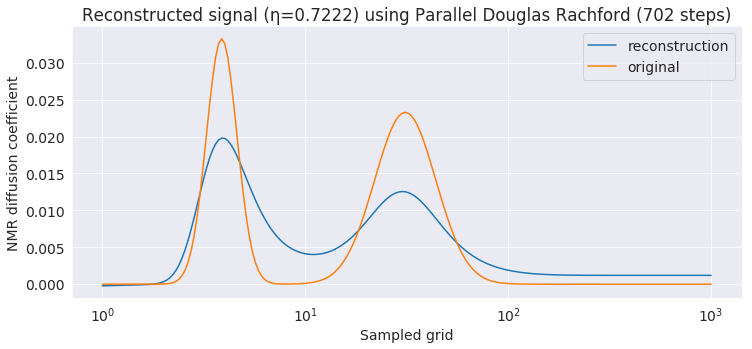

In [35]:
%%time

# Parallel Proximal Algorithm implementation

# Search for best parameter β
best_error = np.inf
best_x_hat = None
best_η = None
best_counter = None
tol = 1e-2 # stopping criterion
#n_iter = 300

η_range = np.linspace(0.5, 1.5, num=10, endpoint=True)

# Set the step size
γ = 0.1
λ = 1.7

# Compute once the matrix inversion
#_inv_prod = np.linalg.inv(K.T.dot(K) + np.eye(N)).dot(np.eye(N) + K.T)
_inv = np.linalg.inv(K.T.dot(K) + np.eye(N))

for η in η_range:    

    # Initialization
    x_curr_1 = np.zeros_like(x)
    x_curr_2 = K.dot(x_curr_1)
    x_next_1 = np.ones_like(x)
    x_next_2 = K.dot(x_next_1)
    v_curr = _inv.dot(x_curr_1 + K.T.dot(x_curr_2))
    v_next = _inv.dot(x_next_1 + K.T.dot(x_next_2))
    
    counter = 0
    
    # Implement Parallel form of Douglas Rachford algorithm
    while np.any(np.abs(v_next - v_curr) / (np.abs(v_curr) + 1e-8) > tol): # stopping criterion
    #for _ in range(n_iter):
        x_curr_1 = x_next_1
        x_curr_2 = x_next_2
        v_curr = v_next
        
        y_curr_1 = γ * vec_W_func(x_curr_1 / γ - 1 - np.log(γ))
        y_curr_2 = y + (x_curr_2 - y) * np.min([1, σ * np.sqrt(M * η) / np.linalg.norm(x_curr_2 - y)])
        
        c_curr = _inv.dot(y_curr_1 + K.T.dot(y_curr_2))
        
        x_next_1 = x_curr_1 + λ * (2 * c_curr - v_curr - y_curr_1)
        x_next_2 = x_curr_2 + λ * (K.dot(2 * c_curr - v_curr) - y_curr_2)
        
        v_next = v_curr + λ * (c_curr - v_curr)
        
        counter += 1
        
        
    x_hat = v_next
    
    error = quadratic_error(x_hat, x)

    if error < best_error:
        best_error = error
        best_x_hat = x_hat
        best_η = η
        best_counter = counter

# Display the reconstruction error
print(f"Best normalized quadratic error between"
      f" the original and reconstruction signals: {round(best_error, 4)}")

# Display the reconstructed x_hat as a function of T using log scale horizontal axis
plt.figure(figsize=(12, 5))
plt.title(f"Reconstructed signal (η={round(best_η, 4)}) "
          f"using Parallel Douglas Rachford ({best_counter} steps)")
plt.plot(T, best_x_hat, label="reconstruction")
# Display the original signal x as a function of T using log scale horizontal axis
plt.plot(T, x, label="original")
plt.xlabel("Sampled grid")
plt.ylabel("NMR diffusion coefficient")
plt.xscale("log")
plt.legend(frameon=True);

**Comment**:

* We obtain a reconstruction whose normalized reconstruction error falls in between the *Maximum entropy regularization* variants but this time using our prior knowledge of the noise power $\sigma$ allows us to conduct a *fine-grained* grid search for $\eta$ between 0.5 and 1.5. We kept a high tolerance (``tol=1e-2``) as we experienced long computation times and unreasonable solutions at lower tolerance. In addition, we played with the step size of $\gamma$ and $\lambda$.

We summarize our findings below:

Algorithm variant | Best normalized quadratic error | Stopping criterion (tolerance) | Regularization parameter ($\beta$ or $\eta$) | Step size $\gamma$ | Relaxation parameter $\lambda$
--- | --- | --- | --- | --- | ---
*Smoothness prior* | 0.3849 | ``None`` | $\beta = 0.515$ | ``None`` | ``None``
*Smothness prior* + *constraints* | 0.1542 | ``tol=1e-3`` | $\beta = 0.1$ | ${\frac{1}{\nu}}^{(*^1)}$ | ``0.95``
*Sparsity prior* | **0.11** | ``tol=1e-3`` | $\beta=0.1$ | ${\frac{1}{\nu}}^{(*^2)}$ | ``0.95``
*Maximum entropy regularization* (*Forward Backward*) | 0.1409 | ``tol=1e-3`` | $\beta = 5.05 \times 10^{-7}$ | ${\frac{1}{\nu}}^{(*^2)}$ | ``1``
*Maximum entropy regularization* (*Douglas Rachford*) | 0.2472 | ``tol=1e-3`` | $\beta = 10^{-8}$ | ``0.1`` | ``1.9``
*Maximum entropy regularization* (*PPXA+* using *Noise prior*) | 0.2012 | ``tol=1e-2`` | $\eta = 0.722$ | ``0.1`` | ``1.7``

* $(*^1)$: $\nu$ is the largest eigenvalue of $K^T K + \beta D^T D$
* $(*^2)$: $\nu$ is the largent eigenvalue of $K^T K$